Transfer learning is a powerful technique that can save you a lot of time and energy training an image classifier. When conducting transfer learning, you can just take a model that has already been trained and apply it to very similar problems, achieving a working classifier with very little effort. There are many pretrained models available for use, like VGG19 or ResNet50. However, you can also train your own image classifier from scratch and apply it to similar data.

This notebook will demonstrate the theory behind transfer learning, although we will be using one dataset.
We'll be designing an image classifier from the ground up with Keras, and then we'll save our custom trained classifier. 
First, we'll train the classifier on the training set and test it on the test set. We'll save it after this.

We'll then load in the classifier and do some data augmentation/transformation to the validation set to get a slightly different dataset. We'll apply the same transformations to the test set and test our second model on it, to see if our performance has improved even though we've trained it for less time. 

To start off with, we'll need to create our training, validation, and testing datasets. We can do this fairly simply by using the ImageDataGenerator that comes with Keras. We need to start off by specifying the different directories, creating an instance of the ImageDataGenerator, and then using the generator to prep the dataset by flowing the data from the directory.

We'll be creating four sets of data total: a training set for the unchanged data, a testing set for the unchanged data, a training set for the transformed data, and a testing set for the transformed data.

We won't be altering the training data at all with the generator, but we will be altering the validation data. This is so we can see that even though we've applied many perturbations to the image, it still doesn't take very long to train and get a decent accuracy on the validation set.

To begin with, here's the imports we'll need.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

Now we'll define some variables we'll need, as well as handle differnt possible input specifications for our model. Some models want the channels listed first, others don't.

In [ ]:
batch_size = 16
im_height = 150
im_width = 150

# handling the different possible input shapes for the model
if keras.backend.image_data_format() == 'channels_first':
    inp_shape = (3, im_width, im_height)
else:
    inp_shape = (im_width, im_height, 3)

We'll now want to specify the directories and use the ImageDataGenerator to get the image data from the directories. After that, we'll use the generators and make iterables from them using `flow_from_directory`.

In [ ]:
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"

# generate the data for both training and validation data
# when we instantiate the data generator we pass in transformations to use
# rescaling and flipping here
train_1_datagen = ImageDataGenerator(rescale=1. / 255)

train_2_datagen = ImageDataGenerator(rescale=1. /255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, rotation_range=30,
                                     width_shift_range=0., channel_shift_range=0.9, brightness_range=[0.5, 1.5])

test_datagen = ImageDataGenerator(rescale=1. /255)

test_datagen_2 = ImageDataGenerator(rescale=1. /255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, rotation_range=30,
                                     width_shift_range=0., channel_shift_range=0.9, brightness_range=[0.5, 1.5])

# after creating the objects flow from directory
# declare what directory to flow from, as well as image size and batch size
# class mode is binary here, either normal xray or not normal

# we could do "class_mode = binary" here, if so, be sure to make the final output 1 and not 2
train_generator_1 = train_1_datagen.flow_from_directory(train_dir, target_size=(im_width, im_height),
                                                    batch_size=batch_size)

test_generator_1 = test_datagen.flow_from_directory(test_dir, target_size=(im_width, im_height),
                                                    batch_size = batch_size)

train_generator_2 = train_2_datagen.flow_from_directory(val_dir, target_size=(im_width, im_height),
                                                    batch_size = batch_size)

test_generator_2 = test_datagen_2.flow_from_directory(test_dir, target_size=(im_width, im_height),
                                                    batch_size = batch_size)

Let's visualize some of the data to get a better idea of how the datasets will differ. First, we'll visualize the data that is being used to train the first model.

In [ ]:
def image_show(image_generator):
    x, y = image_generator.next()
    fig = plt.figure(figsize=(8, 8))
    columns = 3
    rows = 3
    for i in range(1, 10):
        # img = np.random.randint(10)
        image = x[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(image.transpose(0, 1, 2))
    plt.show()
    
image_show(train_generator_1)

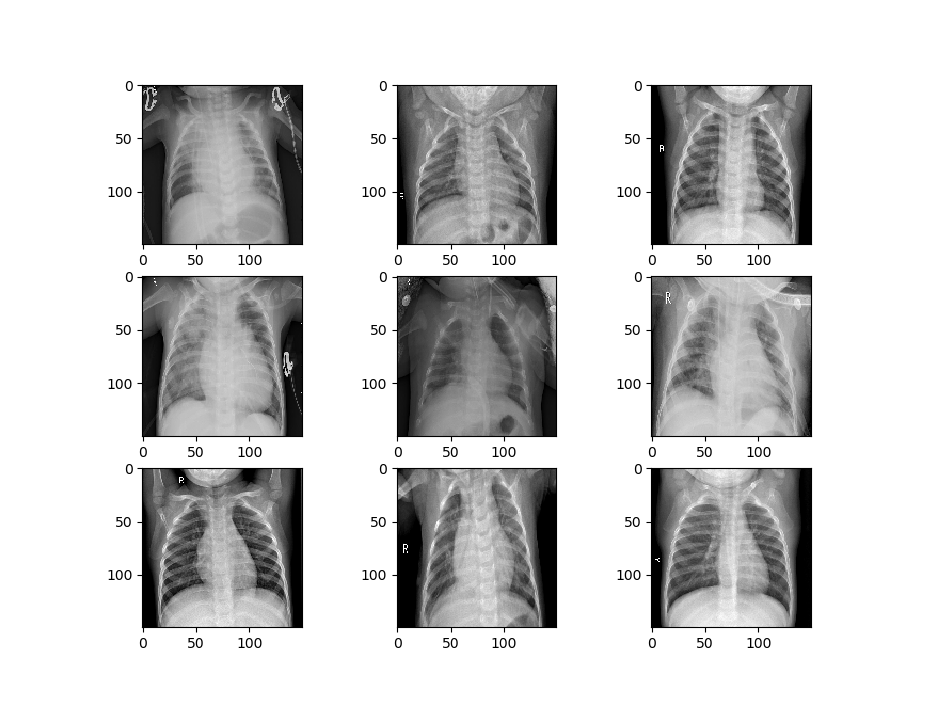

Now we'll visualize the second set of data.

In [ ]:
image_show(train_generator_2)

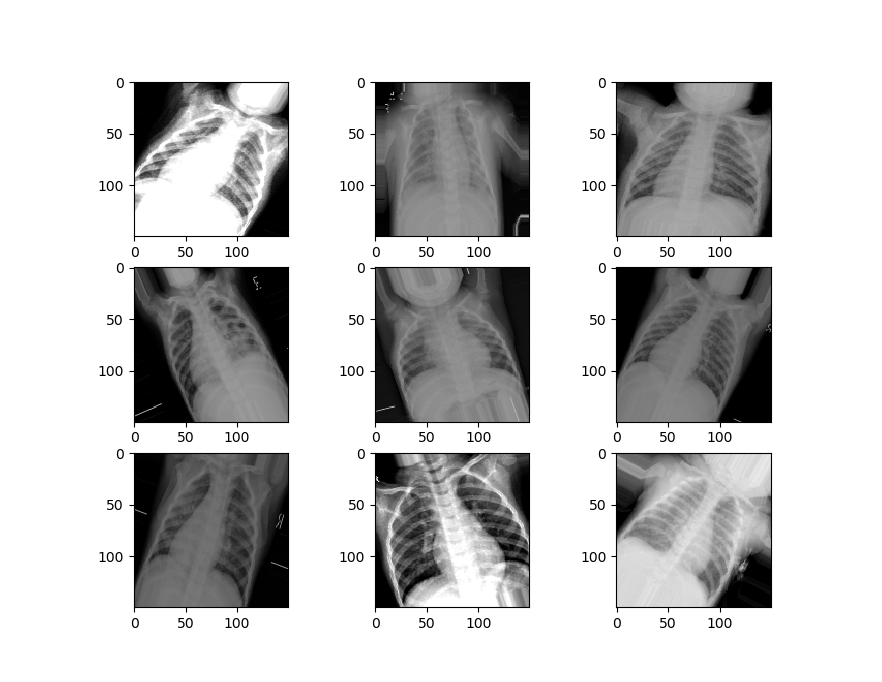

We can see that our second set of data is a little different from the first set. It's zoomed in, rotated randomly, has image artifacting and more, to simulate the kinds of damages that might happen to an image in the real world.

Now we can make a function to handle the creation of our model. This function will establish the sequential model form and add the layers of the convolutional network - with the convolutional layers, the Max Pooling, and some batch normalization. We'll have three of these "blocks" comprising the convolutional layers in our network. These will be followed by a flattening layer, which transforms the data into a long vector that the densely connected layers of the neural network will be able to analyze. We'll then add in our densely connected layers and activation functions, along with some dropout to prevent overfitting. We then compile the model and return it.

In [ ]:
def create_model():
    # first specify the sequential nature of the model
    model = Sequential()
    # second parameter is the size of the "window" you want the CNN to use
    # the shape of the data we are passing in, 3 x 150 x 150
    # last element is just the image in the series, others are pixel widths
    model.add(Conv2D(64, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    # you'll need to flatten the data again if you plan on having Dense layers in the model,
    # as it needs a 1d unlike a 2d CNN
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='sigmoid'))
    # now compile the model, specify loss, optimization, etc
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit the model, specify batch size, validation split and epochs
    return model

model = create_model()

Now we'll create the model by calling the function.

We need to use the `fit_generator` function to fit our model, since we used a data generator to set up the image data. We're also giong to specify some callbacks here, which specify how we want our model to behave while training. The callbacks we will use include: Model Checkpoint - which saves weights occassionally when a specified event happens (in our case when the validation accuracy improves. Reduce LR On Plateau, which reduces the learning rate of our classifier when it hits a plateau and stops improving on the loss. This helps to avoid getting stuck oscillating around minimum loss. Finally, Early Stopping lets us stop training early if we've hit a point where validation loss stops decresing for some given amount of time, which is defined by our "patience".

We pass in these callbacks and then fit the model, saving it in a variable so we can access the training records later.

In [ ]:
filepath = "weights_training_1.hdf5"
callbacks = [ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min', min_lr=0.00001),
              EarlyStopping(monitor= 'val_loss', min_delta=1e-10, patience=15, verbose=1, restore_best_weights=True)]

records = model.fit_generator(train_generator_1, steps_per_epoch=100, epochs=25, validation_data=test_generator_1, validation_steps=7, verbose=1, callbacks=callbacks)

After our training is complete and the best weights have been saved, let's evaluate the performance of our model. We'll create a function that plots the loss and accuracy on the training and validation sets. We'll also evlauate the model's performance using the evaluation metric we specified in the generator, which we can save to a variable and print.

First, we'll need to get the loss on the training and validation sets, which we can draw from the "records" variable.

In [ ]:
t_loss = records.history['loss']
v_loss = records.history['val_loss']
t_acc = records.history['acc']
v_acc = records.history['val_acc']

# gets the lengt of how long the model was trained for
train_length = range(1, len(t_acc) + 1)

Now we'll create the function to evaluate our model's performance.

In [ ]:
def evaluation(model, train_length, training_acc, val_acc, training_loss, validation_loss, generator):

    # plot the loss across the number of epochs
    plt.figure()
    plt.plot(train_length, training_loss, label='Training Loss')
    plt.plot(train_length, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(train_length, training_acc, label='Training Accuracy')
    plt.plot(train_length, val_acc, label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # compare against the test training set
    # get the score/accuracy for the current model
    scores = model.evaluate_generator(generator)
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

We have around 83% accuracy already. Not bad.

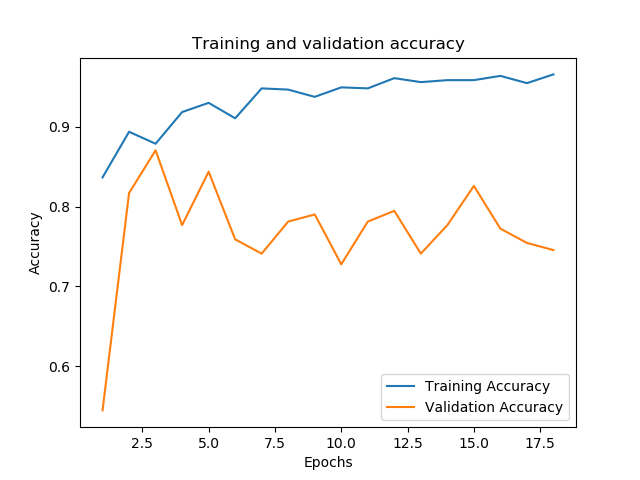
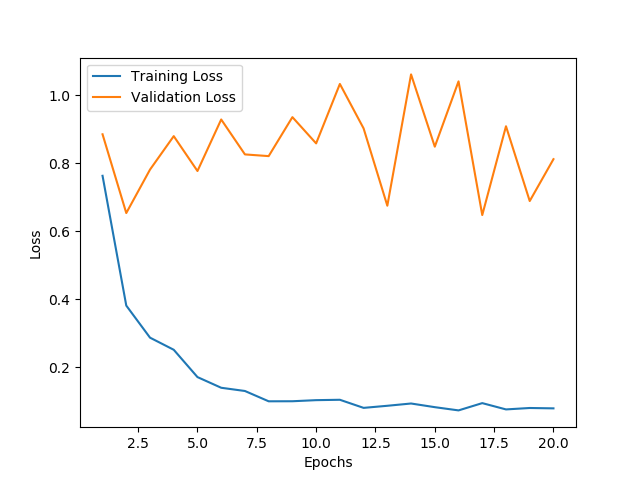

acc: 83.09%

Now we can call the function and evaluate how our model trained along with its perfomance on the dataset.

In [ ]:
evaluation(model, train_length, t_acc, v_acc, t_loss, v_loss, test_generator_1)

We're now going to train a second model that uses the weights and architecture from our first model. We'll load in the trained weights into a second instance of our model. Then we'll specify that we only want to train the last three layers of our model, a portion of the densely connected layers. We can make sure these are set up to train by printing out the trainable layers of the model.

In [ ]:
model_2 = create_model()
model_2.load_weights("weights_training_1.hdf5")

for layer in model_2.layers[:-5]:
    layer.trainable = False

for layer in model_2.layers:
    print(layer, layer.trainable)

Now we just need to compile and fit the model.

In [ ]:
# now compile the model, specify loss, optimization, etc
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the model, specify batch size, validation split and epochs

filepath = "C:/Users/Daniel/Downloads/chest-xray-pneumonia/chest_xray/weights_training_2.hdf5"
callbacks = [ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min', min_lr=0.00001),
              EarlyStopping(monitor= 'val_loss', min_delta=1e-10, patience=15, verbose=1, restore_best_weights=True)]

records = model_2.fit_generator(train_generator_2, steps_per_epoch=85, epochs=20, validation_data=test_generator_2, validation_steps=7, verbose=1, callbacks=callbacks)

Finally, let's check to see how the second model performed by getting its metrics.

In [ ]:
t_loss = records.history['loss']
v_loss = records.history['val_loss']
t_acc = records.history['acc']
v_acc = records.history['val_acc']

# gets the length of how long the model was trained for
train_length = range(1, len(t_acc) + 1)

evaluation(model_2, train_length, t_acc, v_acc, t_loss, v_loss, 80, test_generator_2)

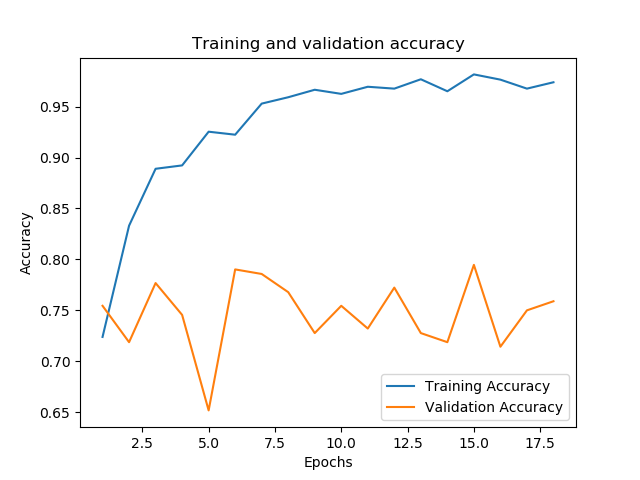
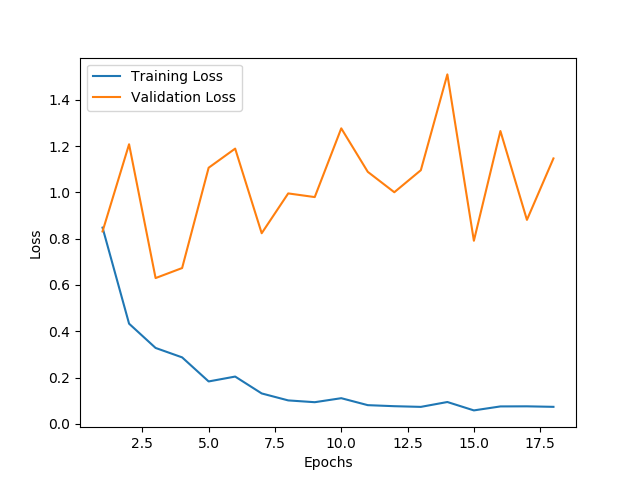

acc: 73.48%

We can see that after training it for only two epochs, and despite the perturbations applied to the dataset, performance quickly hit over 70%.